In [1]:
import random
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model

## Misc

In [2]:
# todo: apply to classes
def make_trainable(net, val, lr=0.001):
    net.model.trainable = val
    for l in net.model.layers:
        l.trainable = val
    net.cmpile(lr)
    
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # при замене оптимизатора всё слетает ???
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def fit_discriminator(discriminator, Data, epochs, lr=0.001):
    make_trainable(discriminator, True, lr=lr)
    #discriminator.trainable = True
    discriminator.fit(Data.x, Data.y, epochs=epochs, plot=True)
    
# Training GAN
def fit_gan(gan, Data, epochs):
    p = Plot('GAN_results')

    for i in range(epochs):
        V = Data.load_random(n_samples=64)
        print("Epoch %d" % i)
        generated = generator.predict(V)
        if i % 10 == 0:
            p.add_to_gif(generated, np.ones(V.shape[0]), title='Epoch %d' % i, alpha=1)
        #make_trainable(discriminator, False)
        print("Fitting GAN")
        gan.fit(V, np.ones(V.shape[0]), epochs=2)
        #make_trainable(discriminator, True)
        print("Fitting discriminator")
        discriminator.fit(generated, np.zeros(V.shape[0]), validation_split=None)
        discriminator.fit(Data.x, Data.y, validation_split=0.2)
    p.save_gif()
    gan.save('gan.h5')


## Data generation class

In [34]:
# To generate data
class Dataset():
    x = None
    y = None
    W = None
    
    def __init__(self):
        return
    
    def load_data(self, data_range=10):
        dots_x = []
        for i in range(data_range):
            x = random.gauss(0, data_range)
            dots_x.append((x, x**2)) # square
            for j in range(4):
                dots_x.append((x, random.gauss(x**2, data_range**2))) # less than square
                #dots_x.append((x**r, x**(2*r*(1+random.gauss(0.5, 0.25)/20)))) # more than square
        dots_x = np.array(dots_x)
        #dots_y = np.array([random.uniform(0.75, 1.2) if x[0]**2 == x[1] else random.uniform(0, 0.3) for x in dots_x])
        dots_y = np.array([1 if x[0]**2 == x[1] else 0 for x in dots_x])
        self.x, self.y = dots_x, dots_y
        return dots_x, dots_y
    
    def load_weights(self, default_weight=0.12):
        W = self.y.copy().astype(float)
        W[W == 0] = 0.12
        self.W = W
        return W
        
    @staticmethod
    def load_random(n_dim=5, n_samples=16):
        V = np.random.normal(size=(n_samples, n_dim))
        return V
    

## Image plotting class

In [29]:
# To plot images
class Plot:
    name = ""
    images = []
    threshold = 0.0
    
    def __init__(self, name, threshold=0.6):
        self.name = name
        self.threshold = threshold
        self.images = []
    
    @staticmethod
    def parabola_plot(ax, xrange):
        x = np.linspace(xrange, 1)
        y = x*x
        plt.plot(x, y)
    
    @staticmethod
    def dots_plot(ax, dots_x, dots_y, color):
        ax.scatter(dots_x, dots_y, color=color, alpha=0.15)
        plt.plot()
    
    def picture(self, dots, predictions, title='', alpha=0.3):
        predictions = predictions.reshape(predictions.shape[0])
        dots_x = dots.T[0]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set(title=title)
        #ax2 = ax1.twinx()
        plt.grid(axis='both')
        xrange = (dots_x.min(), dots_x.max())
        self.parabola_plot(ax1, xrange)
        ax1.scatter(dots.T[0], dots.T[1], c=predictions, cmap='YlOrRd', alpha=alpha)
        
    def add_to_gif(self, dots_x, predictions, title='', alpha=0.3):
        self.picture(dots_x, predictions, title=title, alpha=alpha)
        plt.savefig(self.name+'.png')
        plt.close()
        image = Image.open(self.name+'.png')
        ar = np.asarray(image)
        self.images.append(ar)
        
    def save_gif(self):
        kargs = { 'duration': 0.2 }
        imageio.mimsave(self.name+'.gif', self.images, None, **kargs)
        

## Neural networks classes

In [8]:
# Classes for neural networks

# Generator
class Gen:
    model = None
    
    def __init__(self):
        model = Sequential([tf.keras.layers.LeakyReLU(),
                            Dense(15, input_dim=5, kernel_initializer='he_uniform'),
                            Dense(2, activation='linear')
        ])
        self.model = model
        
    def predict(self, dots_x):
        return self.model.predict(dots_x)
    
    def cmpile(self):
        return
    
# Discriminator
class Dsc:
    model = None
    
    def __init__(self):
        model = Sequential([tf.keras.layers.LeakyReLU(),
                            Dense(25, input_dim=2, kernel_initializer='he_uniform'),
                            Dense(1, activation='sigmoid')
        ])
        self.model = model
    
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
        
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=10, 
                               sample_weight=weights,
                               validation_split=validation_split)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
        

# # Raw classes, don't work 

```python
class Gan:
    gen = None
    dsc = None
    model = None
    
    def __init__(self, gen, dsc, n_dim=5):
        make_trainable(dsc, False)
        self.gen = gen
        self.dsc = dsc
        # connect them
        model = Sequential()
        # add generator
        model.add(gen.model)
        # add the discriminator
        model.add(dsc.model)
        self.model = model
    
    # This method doesn't work
    # Presumably because of some optimizer issue
    def cmpile(self, lr=0.001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics = ['accuracy'])
        
    def fit(self, dots_x, dots_y, epochs=1):
        self.model.fit(dots_x, dots_y, epochs=epochs)
        
class Dummy:
    model = None
    
    def __init__(self, model):
        self.model = model
        
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
    
    # todo: remove hardcode
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs//25):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=25, 
                               sample_weight=weights)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i*25)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
```

In [6]:
#discriminator = tf.keras.models.load_model('discriminator.h5')

# Start Here

In [35]:
# Generating data
Data = Dataset()
Data.load_data(data_range=1000)
weights = Data.load_weights()

# Defining neural networks
generator = Gen()
discriminator = Dsc()


In [36]:
fit_discriminator(discriminator, Data, 200, lr=0.01)

Epoch 0 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 333us/sample - loss: 49297.5242 - acc: 0.5487 - val_loss: 1766.5903 - val_acc: 0.5707
Epoch 2/10
4250/4250 [==============================] - 1s 218us/sample - loss: 18906.2685 - acc: 0.5534 - val_loss: 7796.1712 - val_acc: 0.5547
Epoch 3/10
4250/4250 [==============================] - 1s 271us/sample - loss: 13515.6579 - acc: 0.5532 - val_loss: 14203.4100 - val_acc: 0.5413
Epoch 4/10
4250/4250 [==============================] - 1s 232us/sample - loss: 14431.4179 - acc: 0.5546 - val_loss: 4631.5997 - val_acc: 0.5587
Epoch 5/10
4250/4250 [==============================] - 1s 243us/sample - loss: 12511.5800 - acc: 0.5536 - val_loss: 9831.5083 - val_acc: 0.5493
Epoch 6/10
4250/4250 [==============================] - 1s 255us/sample - loss: 18878.4384 - acc: 0.5513 - val_loss: 8548.2822 - val_acc: 0.5560
Epoch 7/10
4250/4250 [==============================] - 1s 223u

Epoch 5/10
4250/4250 [==============================] - 1s 236us/sample - loss: 4076.7743 - acc: 0.5522 - val_loss: 7286.0675 - val_acc: 0.5413
Epoch 6/10
4250/4250 [==============================] - 1s 245us/sample - loss: 4224.5184 - acc: 0.5694 - val_loss: 3662.3309 - val_acc: 0.5493
Epoch 7/10
4250/4250 [==============================] - 1s 246us/sample - loss: 7079.5943 - acc: 0.5369 - val_loss: 2793.9086 - val_acc: 0.5573
Epoch 8/10
4250/4250 [==============================] - 1s 254us/sample - loss: 6134.4598 - acc: 0.5459 - val_loss: 6054.4639 - val_acc: 0.5427
Epoch 9/10
4250/4250 [==============================] - 1s 241us/sample - loss: 5255.3775 - acc: 0.5595 - val_loss: 2655.9925 - val_acc: 0.4333
Epoch 10/10
4250/4250 [==============================] - 1s 231us/sample - loss: 4652.4903 - acc: 0.5536 - val_loss: 4419.4575 - val_acc: 0.5427
Epoch 6 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 251us/samp

4250/4250 [==============================] - 1s 235us/sample - loss: 102.7632 - acc: 0.6805 - val_loss: 52.8886 - val_acc: 0.7693
Epoch 4/10
4250/4250 [==============================] - 1s 261us/sample - loss: 293.3401 - acc: 0.6089 - val_loss: 293.5663 - val_acc: 0.5840
Epoch 5/10
4250/4250 [==============================] - 1s 211us/sample - loss: 151.8435 - acc: 0.6894 - val_loss: 61.2081 - val_acc: 0.7440
Epoch 6/10
4250/4250 [==============================] - 1s 247us/sample - loss: 52.9930 - acc: 0.7285 - val_loss: 26.4287 - val_acc: 0.5960
Epoch 7/10
4250/4250 [==============================] - 1s 228us/sample - loss: 64.2289 - acc: 0.7125 - val_loss: 38.7175 - val_acc: 0.7933
Epoch 8/10
4250/4250 [==============================] - 1s 223us/sample - loss: 48.1903 - acc: 0.7346 - val_loss: 13.6841 - val_acc: 0.7960
Epoch 9/10
4250/4250 [==============================] - 1s 257us/sample - loss: 87.6519 - acc: 0.6868 - val_loss: 24.2969 - val_acc: 0.8000
Epoch 10/10
4250/4250 [====

4250/4250 [==============================] - 1s 218us/sample - loss: 0.6199 - acc: 0.7911 - val_loss: 0.5884 - val_acc: 0.8000
Epoch 6/10
4250/4250 [==============================] - 1s 219us/sample - loss: 0.5561 - acc: 0.7934 - val_loss: 0.5412 - val_acc: 0.8000
Epoch 7/10
4250/4250 [==============================] - 1s 209us/sample - loss: 0.5184 - acc: 0.7988 - val_loss: 0.5090 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 220us/sample - loss: 0.5301 - acc: 0.7918 - val_loss: 0.5174 - val_acc: 0.8000
Epoch 9/10
4250/4250 [==============================] - 1s 218us/sample - loss: 0.5040 - acc: 0.7995 - val_loss: 0.5032 - val_acc: 0.8000
Epoch 10/10
4250/4250 [==============================] - 1s 219us/sample - loss: 0.5078 - acc: 0.7991 - val_loss: 0.5001 - val_acc: 0.8000
Epoch 28 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 198us/sample - loss: 0.5065 - acc: 0.7981 - val_loss: 0.

4250/4250 [==============================] - 1s 215us/sample - loss: 0.5165 - acc: 0.7988 - val_loss: 0.5059 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 200us/sample - loss: 0.5158 - acc: 0.7965 - val_loss: 0.5037 - val_acc: 0.8000
Epoch 9/10
4250/4250 [==============================] - 1s 210us/sample - loss: 0.5092 - acc: 0.7984 - val_loss: 0.5002 - val_acc: 0.8000
Epoch 10/10
4250/4250 [==============================] - 1s 222us/sample - loss: 0.5132 - acc: 0.7988 - val_loss: 0.5089 - val_acc: 0.8000
Epoch 39 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 300us/sample - loss: 0.5097 - acc: 0.7988 - val_loss: 0.5033 - val_acc: 0.8000
Epoch 2/10
4250/4250 [==============================] - 1s 236us/sample - loss: 0.5289 - acc: 0.7901 - val_loss: 0.5249 - val_acc: 0.7987
Epoch 3/10
4250/4250 [==============================] - 1s 205us/sample - loss: 0.5551 - acc: 0.7852 - val_loss: 0.

4250/4250 [==============================] - 1s 255us/sample - loss: 0.5358 - acc: 0.7948 - val_loss: 0.5349 - val_acc: 0.7800
Epoch 9/10
4250/4250 [==============================] - 1s 231us/sample - loss: 0.5465 - acc: 0.7842 - val_loss: 0.5038 - val_acc: 0.8000
Epoch 10/10
4250/4250 [==============================] - 1s 236us/sample - loss: 0.7447 - acc: 0.7635 - val_loss: 0.7124 - val_acc: 0.8000
Epoch 50 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 267us/sample - loss: 1.0049 - acc: 0.7466 - val_loss: 0.8969 - val_acc: 0.7773
Epoch 2/10
4250/4250 [==============================] - 1s 240us/sample - loss: 828.9977 - acc: 0.5496 - val_loss: 226.4494 - val_acc: 0.5400
Epoch 3/10
4250/4250 [==============================] - 1s 232us/sample - loss: 99.4635 - acc: 0.5826 - val_loss: 9.3948 - val_acc: 0.6093
Epoch 4/10
4250/4250 [==============================] - 1s 257us/sample - loss: 23.0554 - acc: 0.6005 - val_lo

Epoch 4/10
4250/4250 [==============================] - 1s 213us/sample - loss: 0.5131 - acc: 0.7972 - val_loss: 0.5033 - val_acc: 0.8000
Epoch 5/10
4250/4250 [==============================] - 1s 208us/sample - loss: 0.5065 - acc: 0.7998 - val_loss: 0.5042 - val_acc: 0.8000
Epoch 6/10
4250/4250 [==============================] - 1s 215us/sample - loss: 0.5114 - acc: 0.7986 - val_loss: 0.4998 - val_acc: 0.8000
Epoch 7/10
4250/4250 [==============================] - 1s 217us/sample - loss: 0.5198 - acc: 0.7944 - val_loss: 0.5188 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 240us/sample - loss: 0.5085 - acc: 0.7998 - val_loss: 0.5001 - val_acc: 0.8000
Epoch 9/10
4250/4250 [==============================] - 1s 252us/sample - loss: 0.5598 - acc: 0.7854 - val_loss: 0.6747 - val_acc: 0.6947
Epoch 10/10
4250/4250 [==============================] - 1s 231us/sample - loss: 31.6797 - acc: 0.6718 - val_loss: 76.0491 - val_acc: 0.5560
Epoch 56 out of 200
Train on 42

Epoch 6/10
4250/4250 [==============================] - 1s 287us/sample - loss: 0.5224 - acc: 0.7960 - val_loss: 0.5029 - val_acc: 0.8000
Epoch 7/10
4250/4250 [==============================] - 1s 240us/sample - loss: 0.5317 - acc: 0.7934 - val_loss: 0.5116 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 256us/sample - loss: 48.5019 - acc: 0.6842 - val_loss: 101.5232 - val_acc: 0.5400
Epoch 9/10
4250/4250 [==============================] - 1s 241us/sample - loss: 2006.8754 - acc: 0.5362 - val_loss: 507.3129 - val_acc: 0.5387
Epoch 10/10
4250/4250 [==============================] - 1s 232us/sample - loss: 783.4004 - acc: 0.5402 - val_loss: 44.8490 - val_acc: 0.4360
Epoch 67 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 251us/sample - loss: 84.6485 - acc: 0.5711 - val_loss: 13.6558 - val_acc: 0.5947
Epoch 2/10
4250/4250 [==============================] - 1s 228us/sample - loss: 3.6749 - ac

Epoch 2/10
4250/4250 [==============================] - 1s 218us/sample - loss: 0.5337 - acc: 0.7939 - val_loss: 0.5015 - val_acc: 0.8000
Epoch 3/10
4250/4250 [==============================] - 1s 232us/sample - loss: 0.5076 - acc: 0.7993 - val_loss: 0.5009 - val_acc: 0.8000
Epoch 4/10
4250/4250 [==============================] - 1s 224us/sample - loss: 0.5138 - acc: 0.7962 - val_loss: 0.5051 - val_acc: 0.8000
Epoch 5/10
4250/4250 [==============================] - 1s 229us/sample - loss: 0.5198 - acc: 0.7948 - val_loss: 0.5253 - val_acc: 0.7947
Epoch 6/10
4250/4250 [==============================] - 1s 234us/sample - loss: 32.9823 - acc: 0.6899 - val_loss: 5.7146 - val_acc: 0.5973
Epoch 7/10
4250/4250 [==============================] - 1s 212us/sample - loss: 3040.9354 - acc: 0.5353 - val_loss: 1579.1426 - val_acc: 0.5387
Epoch 8/10
4250/4250 [==============================] - 1s 218us/sample - loss: 476.5634 - acc: 0.5798 - val_loss: 15.6691 - val_acc: 0.5893
Epoch 9/10
4250/4250 [==

Epoch 9/10
4250/4250 [==============================] - 1s 207us/sample - loss: 0.5716 - acc: 0.7805 - val_loss: 0.5101 - val_acc: 0.8000
Epoch 10/10
4250/4250 [==============================] - 1s 217us/sample - loss: 0.5319 - acc: 0.7913 - val_loss: 0.6771 - val_acc: 0.6733
Epoch 78 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 243us/sample - loss: 462.9027 - acc: 0.5849 - val_loss: 3682.0627 - val_acc: 0.5360
Epoch 2/10
4250/4250 [==============================] - 1s 197us/sample - loss: 1557.5444 - acc: 0.5496 - val_loss: 65.3426 - val_acc: 0.5480
Epoch 3/10
4250/4250 [==============================] - 1s 234us/sample - loss: 16.8960 - acc: 0.6744 - val_loss: 0.9101 - val_acc: 0.8000
Epoch 4/10
4250/4250 [==============================] - 1s 221us/sample - loss: 0.6778 - acc: 0.7882 - val_loss: 0.6396 - val_acc: 0.8000
Epoch 5/10
4250/4250 [==============================] - 1s 219us/sample - loss: 0.5629 - acc: 

4250/4250 [==============================] - 1s 259us/sample - loss: 0.5134 - acc: 0.7965 - val_loss: 0.5013 - val_acc: 0.8000
Epoch 2/10
4250/4250 [==============================] - 1s 269us/sample - loss: 0.5237 - acc: 0.7932 - val_loss: 0.5123 - val_acc: 0.8000
Epoch 3/10
4250/4250 [==============================] - 1s 239us/sample - loss: 0.5350 - acc: 0.7904 - val_loss: 0.5638 - val_acc: 0.8000
Epoch 4/10
4250/4250 [==============================] - 1s 239us/sample - loss: 0.5593 - acc: 0.7831 - val_loss: 0.5171 - val_acc: 0.7947
Epoch 5/10
4250/4250 [==============================] - 1s 235us/sample - loss: 0.9050 - acc: 0.7273 - val_loss: 0.5281 - val_acc: 0.7920
Epoch 6/10
4250/4250 [==============================] - 1s 220us/sample - loss: 52.0087 - acc: 0.5939 - val_loss: 24.3646 - val_acc: 0.5693
Epoch 7/10
4250/4250 [==============================] - 1s 259us/sample - loss: 1877.3406 - acc: 0.5522 - val_loss: 373.8162 - val_acc: 0.4387
Epoch 8/10
4250/4250 [================

4250/4250 [==============================] - 1s 235us/sample - loss: 1.1453 - acc: 0.7478 - val_loss: 25.8287 - val_acc: 0.4387
Epoch 4/10
4250/4250 [==============================] - 1s 203us/sample - loss: 3091.3646 - acc: 0.5365 - val_loss: 6606.3235 - val_acc: 0.5360
Epoch 5/10
4250/4250 [==============================] - 1s 248us/sample - loss: 920.8454 - acc: 0.5548 - val_loss: 17.2502 - val_acc: 0.5840
Epoch 6/10
4250/4250 [==============================] - 1s 216us/sample - loss: 21.7134 - acc: 0.6125 - val_loss: 1.3139 - val_acc: 0.8000
Epoch 7/10
4250/4250 [==============================] - 1s 253us/sample - loss: 1.1227 - acc: 0.7725 - val_loss: 0.7653 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 232us/sample - loss: 0.6339 - acc: 0.7908 - val_loss: 0.5919 - val_acc: 0.8000
Epoch 9/10
4250/4250 [==============================] - 1s 247us/sample - loss: 0.5628 - acc: 0.7953 - val_loss: 0.6019 - val_acc: 0.7533
Epoch 10/10
4250/4250 [===========

4250/4250 [==============================] - 1s 243us/sample - loss: 0.5349 - acc: 0.7960 - val_loss: 0.5388 - val_acc: 0.8000
Epoch 6/10
4250/4250 [==============================] - 1s 218us/sample - loss: 0.5172 - acc: 0.7951 - val_loss: 0.5117 - val_acc: 0.8000
Epoch 7/10
4250/4250 [==============================] - 1s 231us/sample - loss: 0.5225 - acc: 0.7944 - val_loss: 0.5580 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 209us/sample - loss: 6.8055 - acc: 0.6788 - val_loss: 7.8168 - val_acc: 0.5480
Epoch 9/10
4250/4250 [==============================] - 1s 240us/sample - loss: 920.9237 - acc: 0.5353 - val_loss: 383.8130 - val_acc: 0.5360
Epoch 10/10
4250/4250 [==============================] - 1s 262us/sample - loss: 270.0135 - acc: 0.5614 - val_loss: 12.2060 - val_acc: 0.6187
Epoch 112 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 271us/sample - loss: 54.9659 - acc: 0.5984 - val

Epoch 8/10
4250/4250 [==============================] - 1s 244us/sample - loss: 388.9164 - acc: 0.5513 - val_loss: 31.8540 - val_acc: 0.5707
Epoch 9/10
4250/4250 [==============================] - 1s 264us/sample - loss: 6.0195 - acc: 0.7047 - val_loss: 0.7574 - val_acc: 0.7280
Epoch 10/10
4250/4250 [==============================] - 1s 236us/sample - loss: 0.7549 - acc: 0.7784 - val_loss: 0.6230 - val_acc: 0.7947
Epoch 123 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 245us/sample - loss: 0.6248 - acc: 0.7847 - val_loss: 0.5884 - val_acc: 0.7693
Epoch 2/10
4250/4250 [==============================] - 1s 242us/sample - loss: 0.5589 - acc: 0.7894 - val_loss: 0.5166 - val_acc: 0.8000
Epoch 3/10
4250/4250 [==============================] - 1s 245us/sample - loss: 0.5183 - acc: 0.7981 - val_loss: 0.5034 - val_acc: 0.8000
Epoch 4/10
4250/4250 [==============================] - 1s 234us/sample - loss: 0.5260 - acc: 0.7922

Epoch 134 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 246us/sample - loss: 0.5183 - acc: 0.7984 - val_loss: 0.5128 - val_acc: 0.8000
Epoch 2/10
4250/4250 [==============================] - 1s 246us/sample - loss: 0.5426 - acc: 0.7939 - val_loss: 0.5300 - val_acc: 0.7960
Epoch 3/10
4250/4250 [==============================] - 1s 273us/sample - loss: 0.5537 - acc: 0.7824 - val_loss: 0.5269 - val_acc: 0.8000
Epoch 4/10
4250/4250 [==============================] - 1s 272us/sample - loss: 0.6179 - acc: 0.7760 - val_loss: 0.9725 - val_acc: 0.7520
Epoch 5/10
4250/4250 [==============================] - 1s 262us/sample - loss: 3.9092 - acc: 0.7205 - val_loss: 61.3863 - val_acc: 0.4480
Epoch 6/10
4250/4250 [==============================] - 1s 267us/sample - loss: 2227.2118 - acc: 0.5322 - val_loss: 16591.3932 - val_acc: 0.5373
Epoch 7/10
4250/4250 [==============================] - 1s 241us/sample - loss: 4243.8686 - acc:

4250/4250 [==============================] - 1s 238us/sample - loss: 0.5281 - acc: 0.7948 - val_loss: 0.5013 - val_acc: 0.8000
Epoch 4/10
4250/4250 [==============================] - 1s 227us/sample - loss: 9.2971 - acc: 0.6718 - val_loss: 7.8155 - val_acc: 0.5947
Epoch 5/10
4250/4250 [==============================] - 1s 247us/sample - loss: 1517.1832 - acc: 0.5445 - val_loss: 4925.2642 - val_acc: 0.5373
Epoch 6/10
4250/4250 [==============================] - 1s 260us/sample - loss: 1241.9420 - acc: 0.6228 - val_loss: 0.9051 - val_acc: 0.8000
Epoch 7/10
4250/4250 [==============================] - 1s 228us/sample - loss: 0.6857 - acc: 0.7824 - val_loss: 0.5886 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 262us/sample - loss: 0.5728 - acc: 0.7906 - val_loss: 0.5315 - val_acc: 0.8000
Epoch 9/10
4250/4250 [==============================] - 1s 245us/sample - loss: 0.5313 - acc: 0.7974 - val_loss: 0.5105 - val_acc: 0.8000
Epoch 10/10
4250/4250 [=============

4250/4250 [==============================] - 1s 137us/sample - loss: 0.5511 - acc: 0.7934 - val_loss: 0.5419 - val_acc: 0.8000
Epoch 6/10
4250/4250 [==============================] - 1s 248us/sample - loss: 0.5229 - acc: 0.7965 - val_loss: 0.5214 - val_acc: 0.8000
Epoch 7/10
4250/4250 [==============================] - 1s 180us/sample - loss: 0.5154 - acc: 0.7991 - val_loss: 0.5011 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 194us/sample - loss: 0.5073 - acc: 0.8000 - val_loss: 0.5012 - val_acc: 0.8000
Epoch 9/10
4250/4250 [==============================] - 1s 142us/sample - loss: 0.5114 - acc: 0.7974 - val_loss: 0.5001 - val_acc: 0.8000
Epoch 10/10
4250/4250 [==============================] - 1s 161us/sample - loss: 0.5100 - acc: 0.7988 - val_loss: 0.5345 - val_acc: 0.8000
Epoch 157 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 142us/sample - loss: 0.5150 - acc: 0.7974 - val_loss: 0

4250/4250 [==============================] - 1s 235us/sample - loss: 52.0276 - acc: 0.6678 - val_loss: 0.9217 - val_acc: 0.8000
Epoch 8/10
4250/4250 [==============================] - 1s 269us/sample - loss: 0.7637 - acc: 0.7819 - val_loss: 0.6996 - val_acc: 0.8000
Epoch 9/10
4250/4250 [==============================] - 1s 199us/sample - loss: 0.6281 - acc: 0.7911 - val_loss: 0.5663 - val_acc: 0.7987
Epoch 10/10
4250/4250 [==============================] - 1s 202us/sample - loss: 0.5582 - acc: 0.7939 - val_loss: 0.5348 - val_acc: 0.8000
Epoch 168 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 233us/sample - loss: 0.5233 - acc: 0.7944 - val_loss: 0.5029 - val_acc: 0.8000
Epoch 2/10
4250/4250 [==============================] - 1s 275us/sample - loss: 0.5229 - acc: 0.7958 - val_loss: 0.5127 - val_acc: 0.8000
Epoch 3/10
4250/4250 [==============================] - 1s 218us/sample - loss: 0.5200 - acc: 0.7958 - val_loss: 

4250/4250 [==============================] - 1s 260us/sample - loss: 0.5061 - acc: 0.7998 - val_loss: 0.5003 - val_acc: 0.8000
Epoch 10/10
4250/4250 [==============================] - 1s 226us/sample - loss: 0.5071 - acc: 0.8000 - val_loss: 0.5112 - val_acc: 0.8000
Epoch 179 out of 200
Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 1s 153us/sample - loss: 0.5186 - acc: 0.7976 - val_loss: 0.5075 - val_acc: 0.8000
Epoch 2/10
4250/4250 [==============================] - 1s 195us/sample - loss: 0.5098 - acc: 0.7984 - val_loss: 0.5093 - val_acc: 0.8000
Epoch 3/10
4250/4250 [==============================] - 1s 337us/sample - loss: 0.5131 - acc: 0.7991 - val_loss: 0.5053 - val_acc: 0.8000
Epoch 4/10
4250/4250 [==============================] - 1s 236us/sample - loss: 0.5073 - acc: 0.7986 - val_loss: 0.5003 - val_acc: 0.8000
Epoch 5/10
4250/4250 [==============================] - 1s 309us/sample - loss: 0.5093 - acc: 0.7998 - val_loss: 0

4250/4250 [==============================] - 1s 303us/sample - loss: 1493.5530 - acc: 0.5468 - val_loss: 4809.8699 - val_acc: 0.4573
Epoch 2/10
4250/4250 [==============================] - 1s 293us/sample - loss: 368.6139 - acc: 0.5929 - val_loss: 8.7226 - val_acc: 0.4653
Epoch 3/10
4250/4250 [==============================] - 1s 322us/sample - loss: 2.3048 - acc: 0.7459 - val_loss: 0.6688 - val_acc: 0.7987
Epoch 4/10
4250/4250 [==============================] - 1s 241us/sample - loss: 0.6911 - acc: 0.7856 - val_loss: 0.5782 - val_acc: 0.7907
Epoch 5/10
4250/4250 [==============================] - 1s 267us/sample - loss: 0.5647 - acc: 0.7915 - val_loss: 0.5867 - val_acc: 0.7973
Epoch 6/10
4250/4250 [==============================] - 1s 291us/sample - loss: 0.5548 - acc: 0.7896 - val_loss: 0.5415 - val_acc: 0.7800
Epoch 7/10
4250/4250 [==============================] - 1s 301us/sample - loss: 0.5196 - acc: 0.7965 - val_loss: 0.5109 - val_acc: 0.8000
Epoch 8/10
4250/4250 [===============

In [9]:
TestData = Dataset()
TestData.load_data(data_range=15)
discriminator.model.evaluate(TestData.x, TestData.y)

1800/1800 [==============================] - 0s 114us/sample - loss: 0.1760 - acc: 0.9017


[0.17600894825326072, 0.90166664]

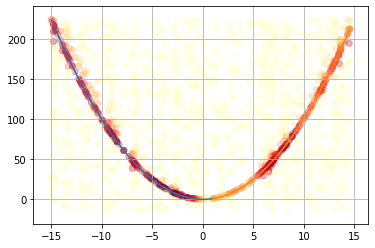

In [29]:
Plot('test2').picture(TestData.x, discriminator.model.predict(TestData.x))

In [18]:
NewData = Dataset()
NewData.load_data(data_range=15)

(array([[-13.9137895 , 193.59353821],
        [-13.9137895 , 166.8826954 ],
        [-13.9137895 ,   3.34478453],
        ...,
        [-14.62422688, 180.63495714],
        [-14.62422688,  79.86063019],
        [-14.62422688, 122.36550899]]), array([1, 0, 0, ..., 0, 0, 0]))

In [13]:
gan = define_gan(generator.model, discriminator.model)

In [19]:
fit_gan(gan, NewData, 800)

Epoch 0
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.1178
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.1157
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.4399 - acc: 0.9062
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 215us/sample - loss: 0.1458 - acc: 0.9215 - val_loss: 0.1482 - val_acc: 0.9472
Epoch 1
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.1845
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1803
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.4027 - acc: 0.9219
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 230us/sample - loss: 0.1387 - acc: 0.9340 - val_loss: 0.1577 - val_acc: 0.9333
Epoch 2
Fitting GAN
Epoch 1/2
64/64 [==============================]

Epoch 35
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.2980
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.2966
Fitting discriminator
64/64 [==============================] - 0s 374us/sample - loss: 0.3583 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 191us/sample - loss: 0.1486 - acc: 0.9292 - val_loss: 0.1564 - val_acc: 0.9417
Epoch 36
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2386
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2377
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.4025 - acc: 0.8594
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 192us/sample - loss: 0.1586 - acc: 0.9229 - val_loss: 0.1919 - val_acc: 0.8833
Epoch 37
Fitting GAN
Epoch 1/2
64/64 [============================

Epoch 70
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 278us/sample - loss: 1.3269
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.3266
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.3348 - acc: 0.9688
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 192us/sample - loss: 0.1577 - acc: 0.9125 - val_loss: 0.1852 - val_acc: 0.8917
Epoch 71
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2592
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2537
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.3684 - acc: 0.9688
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 165us/sample - loss: 0.1464 - acc: 0.9319 - val_loss: 0.1648 - val_acc: 0.9361
Epoch 72
Fitting GAN
Epoch 1/2
64/64 [============================

Epoch 105
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.3125
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.3116
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.3667 - acc: 0.8906
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 198us/sample - loss: 0.1378 - acc: 0.9319 - val_loss: 0.1579 - val_acc: 0.9472
Epoch 106
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 280us/sample - loss: 1.1819
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss: 1.1808
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.4250 - acc: 0.8281
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 197us/sample - loss: 0.1557 - acc: 0.9208 - val_loss: 0.1675 - val_acc: 0.9278
Epoch 107
Fitting GAN
Epoch 1/2
64/64 [=========================

1440/1440 [==============================] - 0s 257us/sample - loss: 0.1441 - acc: 0.9299 - val_loss: 0.1687 - val_acc: 0.9306
Epoch 140
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 200us/sample - loss: 1.2746
Epoch 2/2
64/64 [==============================] - 0s 306us/sample - loss: 1.2478
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.4415 - acc: 0.7969
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 248us/sample - loss: 0.1392 - acc: 0.9382 - val_loss: 0.1528 - val_acc: 0.9528
Epoch 141
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 352us/sample - loss: 1.1586
Epoch 2/2
64/64 [==============================] - 0s 361us/sample - loss: 1.1591
Fitting discriminator
64/64 [==============================] - 0s 418us/sample - loss: 0.4358 - acc: 0.8281
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 249us/sample - l

64/64 [==============================] - 0s 269us/sample - loss: 0.3730 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 255us/sample - loss: 0.1440 - acc: 0.9257 - val_loss: 0.1597 - val_acc: 0.9389
Epoch 175
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 349us/sample - loss: 1.1572
Epoch 2/2
64/64 [==============================] - 0s 373us/sample - loss: 1.1602
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.4331 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 248us/sample - loss: 0.1454 - acc: 0.9292 - val_loss: 0.2503 - val_acc: 0.8806
Epoch 176
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 228us/sample - loss: 1.0412
Epoch 2/2
64/64 [==============================] - 0s 285us/sample - loss: 1.0393
Fitting discriminator
64/64 [==============================] - 0s 287us/sample - loss:

Epoch 192
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 277us/sample - loss: 1.0577
Epoch 2/2
64/64 [==============================] - 0s 323us/sample - loss: 1.0512
Fitting discriminator
64/64 [==============================] - 0s 515us/sample - loss: 0.5086 - acc: 0.7188
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 263us/sample - loss: 0.1545 - acc: 0.9222 - val_loss: 0.1967 - val_acc: 0.9278
Epoch 193
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 230us/sample - loss: 1.1003
Epoch 2/2
64/64 [==============================] - 0s 334us/sample - loss: 1.0982
Fitting discriminator
64/64 [==============================] - 0s 297us/sample - loss: 0.4931 - acc: 0.7656
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 224us/sample - loss: 0.1479 - acc: 0.9229 - val_loss: 0.1688 - val_acc: 0.9333
Epoch 194
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 227
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 269us/sample - loss: 1.2016
Epoch 2/2
64/64 [==============================] - 0s 313us/sample - loss: 1.2062
Fitting discriminator
64/64 [==============================] - 0s 389us/sample - loss: 0.4236 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 276us/sample - loss: 0.1384 - acc: 0.9319 - val_loss: 0.1839 - val_acc: 0.8972
Epoch 228
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 369us/sample - loss: 1.1669
Epoch 2/2
64/64 [==============================] - 0s 279us/sample - loss: 1.1676
Fitting discriminator
64/64 [==============================] - 0s 257us/sample - loss: 0.4152 - acc: 0.8906
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 227us/sample - loss: 0.1654 - acc: 0.9194 - val_loss: 0.2019 - val_acc: 0.8778
Epoch 229
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 262
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 217us/sample - loss: 1.0632
Epoch 2/2
64/64 [==============================] - 0s 291us/sample - loss: 1.0640
Fitting discriminator
64/64 [==============================] - 0s 257us/sample - loss: 0.4765 - acc: 0.8906
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 247us/sample - loss: 0.1533 - acc: 0.9236 - val_loss: 0.1815 - val_acc: 0.8889
Epoch 263
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 224us/sample - loss: 1.1717
Epoch 2/2
64/64 [==============================] - 0s 322us/sample - loss: 1.1691
Fitting discriminator
64/64 [==============================] - 0s 317us/sample - loss: 0.4133 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 276us/sample - loss: 0.1434 - acc: 0.9271 - val_loss: 0.1529 - val_acc: 0.9472
Epoch 264
Fitting GAN
Epoch 1/2
64/64 [=========================

1440/1440 [==============================] - 0s 239us/sample - loss: 0.1444 - acc: 0.9319 - val_loss: 0.1513 - val_acc: 0.9250
Epoch 297
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 164us/sample - loss: 0.9781
Epoch 2/2
64/64 [==============================] - 0s 384us/sample - loss: 0.9750
Fitting discriminator
64/64 [==============================] - 0s 837us/sample - loss: 0.5318 - acc: 0.8438
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 278us/sample - loss: 0.1433 - acc: 0.9285 - val_loss: 0.1608 - val_acc: 0.8889
Epoch 298
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 227us/sample - loss: 1.2707
Epoch 2/2
64/64 [==============================] - 0s 321us/sample - loss: 1.2397
Fitting discriminator
64/64 [==============================] - ETA: 0s - loss: 0.4063 - acc: 0.968 - 0s 371us/sample - loss: 0.3802 - acc: 0.9844
Train on 1440 samples, validate on 360 samples
1440/1440 [===============

64/64 [==============================] - 0s 286us/sample - loss: 0.4919 - acc: 0.8438
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 245us/sample - loss: 0.1424 - acc: 0.9306 - val_loss: 0.1717 - val_acc: 0.9000
Epoch 332
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 393us/sample - loss: 1.1741
Epoch 2/2
64/64 [==============================] - 0s 456us/sample - loss: 1.1645
Fitting discriminator
64/64 [==============================] - 0s 491us/sample - loss: 0.4174 - acc: 0.9688
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 247us/sample - loss: 0.1441 - acc: 0.9222 - val_loss: 0.1599 - val_acc: 0.9361
Epoch 333
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 267us/sample - loss: 0.9902
Epoch 2/2
64/64 [==============================] - 0s 302us/sample - loss: 0.9877
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss:

Epoch 349
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 232us/sample - loss: 0.9796
Epoch 2/2
64/64 [==============================] - 0s 259us/sample - loss: 0.9741
Fitting discriminator
64/64 [==============================] - 0s 285us/sample - loss: 0.4996 - acc: 0.8125
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 214us/sample - loss: 0.1491 - acc: 0.9215 - val_loss: 0.1889 - val_acc: 0.9056
Epoch 350
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 181us/sample - loss: 0.9964
Epoch 2/2
64/64 [==============================] - 0s 347us/sample - loss: 0.9918
Fitting discriminator
64/64 [==============================] - 0s 309us/sample - loss: 0.4962 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 276us/sample - loss: 0.1460 - acc: 0.9299 - val_loss: 0.1579 - val_acc: 0.9389
Epoch 351
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 384
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 245us/sample - loss: 1.1132
Epoch 2/2
64/64 [==============================] - 0s 246us/sample - loss: 1.0938
Fitting discriminator
64/64 [==============================] - 0s 398us/sample - loss: 0.4353 - acc: 0.9531
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 234us/sample - loss: 0.1509 - acc: 0.9194 - val_loss: 0.1507 - val_acc: 0.9389
Epoch 385
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 159us/sample - loss: 1.0360
Epoch 2/2
64/64 [==============================] - 0s 186us/sample - loss: 1.0316
Fitting discriminator
64/64 [==============================] - 0s 226us/sample - loss: 0.4813 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 242us/sample - loss: 0.1445 - acc: 0.9271 - val_loss: 0.1668 - val_acc: 0.8806
Epoch 386
Fitting GAN
Epoch 1/2
64/64 [=========================

1440/1440 [==============================] - 0s 226us/sample - loss: 0.1421 - acc: 0.9243 - val_loss: 0.1932 - val_acc: 0.9028
Epoch 419
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 281us/sample - loss: 1.0849
Epoch 2/2
64/64 [==============================] - 0s 247us/sample - loss: 1.0710
Fitting discriminator
64/64 [==============================] - 0s 215us/sample - loss: 0.5074 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 213us/sample - loss: 0.1751 - acc: 0.9160 - val_loss: 0.1899 - val_acc: 0.9000
Epoch 420
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 224us/sample - loss: 1.0282
Epoch 2/2
64/64 [==============================] - 0s 284us/sample - loss: 1.0298
Fitting discriminator
64/64 [==============================] - 0s 295us/sample - loss: 0.5217 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 254us/sample - l

64/64 [==============================] - 0s 260us/sample - loss: 1.0033
Fitting discriminator
64/64 [==============================] - 0s 251us/sample - loss: 0.4894 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 250us/sample - loss: 0.1452 - acc: 0.9243 - val_loss: 0.1495 - val_acc: 0.9444
Epoch 437
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 348us/sample - loss: 1.0727
Epoch 2/2
64/64 [==============================] - 0s 324us/sample - loss: 1.0682
Fitting discriminator
64/64 [==============================] - 0s 337us/sample - loss: 0.4617 - acc: 0.9062
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 273us/sample - loss: 0.1437 - acc: 0.9243 - val_loss: 0.1484 - val_acc: 0.9361
Epoch 438
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 343us/sample - loss: 0.9582
Epoch 2/2
64/64 [==============================] - 0s 298us/sample - loss:

64/64 [==============================] - 0s 245us/sample - loss: 1.0812
Fitting discriminator
64/64 [==============================] - 0s 225us/sample - loss: 0.4661 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 246us/sample - loss: 0.1480 - acc: 0.9257 - val_loss: 0.1559 - val_acc: 0.9361
Epoch 472
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 350us/sample - loss: 1.1106
Epoch 2/2
64/64 [==============================] - 0s 338us/sample - loss: 1.0991
Fitting discriminator
64/64 [==============================] - 0s 334us/sample - loss: 0.4354 - acc: 0.9844
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 286us/sample - loss: 0.1388 - acc: 0.9292 - val_loss: 0.1486 - val_acc: 0.9417
Epoch 473
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 321us/sample - loss: 1.0181
Epoch 2/2
64/64 [==============================] - 0s 492us/sample - loss:

64/64 [==============================] - 0s 260us/sample - loss: 1.1168
Fitting discriminator
64/64 [==============================] - 0s 277us/sample - loss: 0.4060 - acc: 1.0000
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 232us/sample - loss: 0.1479 - acc: 0.9250 - val_loss: 0.1528 - val_acc: 0.9306
Epoch 507
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 305us/sample - loss: 1.0264
Epoch 2/2
64/64 [==============================] - 0s 292us/sample - loss: 1.0237
Fitting discriminator
64/64 [==============================] - 0s 283us/sample - loss: 0.4747 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 251us/sample - loss: 0.1444 - acc: 0.9250 - val_loss: 0.1605 - val_acc: 0.9306
Epoch 508
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 257us/sample - loss: 1.0268
Epoch 2/2
64/64 [==============================] - 0s 333us/sample - loss:

Epoch 2/2
64/64 [==============================] - 0s 470us/sample - loss: 1.0321
Fitting discriminator
64/64 [==============================] - 0s 216us/sample - loss: 0.4683 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 255us/sample - loss: 0.1497 - acc: 0.9194 - val_loss: 0.2044 - val_acc: 0.9000
Epoch 542
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 372us/sample - loss: 0.9679
Epoch 2/2
64/64 [==============================] - 0s 362us/sample - loss: 0.9646
Fitting discriminator
64/64 [==============================] - 0s 436us/sample - loss: 0.5458 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 241us/sample - loss: 0.1367 - acc: 0.9312 - val_loss: 0.1650 - val_acc: 0.9278
Epoch 543
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 351us/sample - loss: 1.0005
Epoch 2/2
64/64 [==============================] - 0s 399us/samp

1440/1440 [==============================] - 0s 248us/sample - loss: 0.1494 - acc: 0.9236 - val_loss: 0.1494 - val_acc: 0.9417
Epoch 559
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 227us/sample - loss: 1.1044
Epoch 2/2
64/64 [==============================] - 0s 345us/sample - loss: 1.0965
Fitting discriminator
64/64 [==============================] - 0s 330us/sample - loss: 0.4176 - acc: 0.9844
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 282us/sample - loss: 0.1432 - acc: 0.9257 - val_loss: 0.1527 - val_acc: 0.9389
Epoch 560
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 183us/sample - loss: 1.0415
Epoch 2/2
64/64 [==============================] - 0s 323us/sample - loss: 1.0413
Fitting discriminator
64/64 [==============================] - 0s 334us/sample - loss: 0.4917 - acc: 0.9531
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 257us/sample - l

1440/1440 [==============================] - 0s 246us/sample - loss: 0.1450 - acc: 0.9278 - val_loss: 0.1945 - val_acc: 0.9250
Epoch 594
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 231us/sample - loss: 0.9855
Epoch 2/2
64/64 [==============================] - 0s 363us/sample - loss: 0.9845
Fitting discriminator
64/64 [==============================] - 0s 306us/sample - loss: 0.5349 - acc: 0.8906
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 279us/sample - loss: 0.1435 - acc: 0.9299 - val_loss: 0.1763 - val_acc: 0.9194
Epoch 595
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 251us/sample - loss: 1.0725
Epoch 2/2
64/64 [==============================] - 0s 332us/sample - loss: 1.0625
Fitting discriminator
64/64 [==============================] - 0s 429us/sample - loss: 0.4462 - acc: 0.9688
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 237us/sample - l

64/64 [==============================] - 0s 318us/sample - loss: 1.4019
Fitting discriminator
64/64 [==============================] - 0s 237us/sample - loss: 0.4328 - acc: 0.9531
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 260us/sample - loss: 0.1498 - acc: 0.9201 - val_loss: 0.2144 - val_acc: 0.8667
Epoch 612
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 391us/sample - loss: 1.0629
Epoch 2/2
64/64 [==============================] - 0s 308us/sample - loss: 1.0596
Fitting discriminator
64/64 [==============================] - 0s 526us/sample - loss: 0.4400 - acc: 1.0000
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 282us/sample - loss: 0.1639 - acc: 0.9187 - val_loss: 0.1593 - val_acc: 0.9250
Epoch 613
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 334us/sample - loss: 0.9473
Epoch 2/2
64/64 [==============================] - 0s 305us/sample - loss:

1440/1440 [==============================] - 0s 246us/sample - loss: 0.1388 - acc: 0.9347 - val_loss: 0.1486 - val_acc: 0.9417
Epoch 629
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 325us/sample - loss: 0.9824
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 0.9825
Fitting discriminator
64/64 [==============================] - 0s 303us/sample - loss: 0.5295 - acc: 0.9062
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 262us/sample - loss: 0.1533 - acc: 0.9208 - val_loss: 0.1611 - val_acc: 0.9056
Epoch 630
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 231us/sample - loss: 0.9103
Epoch 2/2
64/64 [==============================] - 0s 341us/sample - loss: 0.9062
Fitting discriminator
64/64 [==============================] - 0s 283us/sample - loss: 0.5814 - acc: 0.8906
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 261us/sample - l

64/64 [==============================] - 0s 432us/sample - loss: 1.1936
Fitting discriminator
64/64 [==============================] - 0s 260us/sample - loss: 0.4676 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 237us/sample - loss: 0.1457 - acc: 0.9215 - val_loss: 0.2695 - val_acc: 0.8778
Epoch 647
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 308us/sample - loss: 1.0548
Epoch 2/2
64/64 [==============================] - 0s 366us/sample - loss: 1.0657
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.4517 - acc: 0.9375
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 268us/sample - loss: 0.1723 - acc: 0.9139 - val_loss: 0.1543 - val_acc: 0.9333
Epoch 648
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 239us/sample - loss: 0.9630
Epoch 2/2
64/64 [==============================] - 0s 359us/sample - loss:

64/64 [==============================] - 0s 271us/sample - loss: 0.9937
Fitting discriminator
64/64 [==============================] - 0s 227us/sample - loss: 0.4874 - acc: 0.9531
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 220us/sample - loss: 0.1466 - acc: 0.9229 - val_loss: 0.1539 - val_acc: 0.9333
Epoch 682
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 354us/sample - loss: 0.9789
Epoch 2/2
64/64 [==============================] - 0s 403us/sample - loss: 0.9718
Fitting discriminator
64/64 [==============================] - 0s 325us/sample - loss: 0.5280 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 278us/sample - loss: 0.1534 - acc: 0.9215 - val_loss: 0.1615 - val_acc: 0.9333
Epoch 683
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 222us/sample - loss: 1.0733
Epoch 2/2
64/64 [==============================] - 0s 272us/sample - loss:

64/64 [==============================] - 0s 264us/sample - loss: 0.9826
Epoch 2/2
64/64 [==============================] - 0s 384us/sample - loss: 0.9907
Fitting discriminator
64/64 [==============================] - 0s 317us/sample - loss: 0.5468 - acc: 0.9219
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 239us/sample - loss: 0.1308 - acc: 0.9292 - val_loss: 0.1807 - val_acc: 0.9139
Epoch 717
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 334us/sample - loss: 0.9248
Epoch 2/2
64/64 [==============================] - 0s 323us/sample - loss: 0.9226
Fitting discriminator
64/64 [==============================] - 0s 309us/sample - loss: 0.5703 - acc: 0.8906
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 273us/sample - loss: 0.1318 - acc: 0.9347 - val_loss: 0.2171 - val_acc: 0.8889
Epoch 718
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 232us/sample - loss:

Epoch 751
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 200us/sample - loss: 0.9516
Epoch 2/2
64/64 [==============================] - 0s 173us/sample - loss: 0.9527
Fitting discriminator
64/64 [==============================] - 0s 310us/sample - loss: 0.5701 - acc: 0.8594
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 252us/sample - loss: 0.1609 - acc: 0.9222 - val_loss: 0.2007 - val_acc: 0.8778
Epoch 752
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 531us/sample - loss: 1.0173
Epoch 2/2
64/64 [==============================] - 0s 282us/sample - loss: 1.0127
Fitting discriminator
64/64 [==============================] - 0s 266us/sample - loss: 0.5184 - acc: 0.9219
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 239us/sample - loss: 0.1493 - acc: 0.9292 - val_loss: 0.1580 - val_acc: 0.9083
Epoch 753
Fitting GAN
Epoch 1/2
64/64 [=========================

64/64 [==============================] - 0s 262us/sample - loss: 0.5003 - acc: 0.8906
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 249us/sample - loss: 0.1530 - acc: 0.9243 - val_loss: 0.1628 - val_acc: 0.9333
Epoch 769
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 305us/sample - loss: 1.0149
Epoch 2/2
64/64 [==============================] - 0s 339us/sample - loss: 1.0130
Fitting discriminator
64/64 [==============================] - 0s 314us/sample - loss: 0.4818 - acc: 0.9688
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 222us/sample - loss: 0.1400 - acc: 0.9319 - val_loss: 0.1619 - val_acc: 0.9167
Epoch 770
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 183us/sample - loss: 1.0154
Epoch 2/2
64/64 [==============================] - 0s 256us/sample - loss: 1.0130
Fitting discriminator
64/64 [==============================] - 0s 298us/sample - loss:

Epoch 786
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 230us/sample - loss: 1.0120
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.0105
Fitting discriminator
64/64 [==============================] - 0s 275us/sample - loss: 0.5362 - acc: 0.8750
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 225us/sample - loss: 0.1412 - acc: 0.9306 - val_loss: 0.1659 - val_acc: 0.9278
Epoch 787
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 304us/sample - loss: 1.0303
Epoch 2/2
64/64 [==============================] - 0s 260us/sample - loss: 1.0269
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.4669 - acc: 0.9688
Train on 1440 samples, validate on 360 samples
1440/1440 [==============================] - 0s 222us/sample - loss: 0.1369 - acc: 0.9257 - val_loss: 0.1510 - val_acc: 0.9222
Epoch 788
Fitting GAN
Epoch 1/2
64/64 [=========================

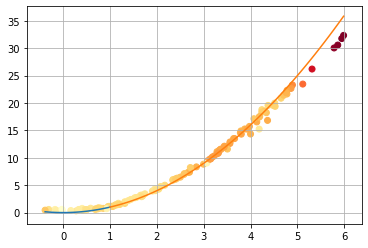

In [22]:
N = 128
V = generator.predict(TestData.load_random(n_samples=N))
Plot('test').picture(V, discriminator.model.predict(V), alpha=1)

In [24]:
gan.save('best_gan.h5')

In [25]:
generator.model.save('best_generator.h5')

In [26]:
discriminator.model.save('best_discriminator.h5')

In [28]:
d2 = tf.keras.models.load_model('best_discriminator.h5')

W1021 23:20:47.660903 43904 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1021 23:20:47.716973 43904 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1021 23:20:48.125404 43904 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


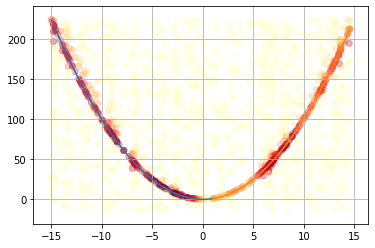

In [31]:
Plot('test2').picture(TestData.x, d2.predict(TestData.x))